Part 1: Data Preprocessing
write separate codes and output for 3 questions
A. Loading the Dataset
1. Load the dataset into a pandas DataFrame.

In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv("sample_data/Activity_data.csv")

# Display shape for confirmation
print("Dataset loaded successfully.")
print(f"Shape: {df.shape}")


Dataset loaded successfully.
Shape: (75128, 9)


2. Display the first few rows and check for any missing values.


In [4]:
# Display first 5 rows
print("First 5 rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


First 5 rows of the dataset:
   Time  frontal_axis_Acceleration  vertical_axis+_Acceleration  \
0  0.00                  -0.232160                     0.215880   
1  0.25                  -0.056282                     0.043636   
2  0.50                   0.143050                     0.296270   
3  0.75                   0.318930                     0.284780   
4  1.05                   0.412730                     0.135500   

   lateral_axis_Acceleration  Antenna_ID_Sensor  RSSI    Phase  Frequency  \
0                   -1.18820                  2 -48.5  2.74430     920.75   
1                   -1.14260                  2 -50.0  2.36540     921.75   
2                   -1.33640                  3 -59.5  0.20709     922.25   
3                   -0.92593                  2 -51.0  0.41571     923.25   
4                   -1.02860                  2 -44.5  4.45470     920.25   

   Activity  
0         3  
1         3  
2         3  
3         3  
4         3  

Missing values per c

3. Handle missing values appropriately (remove or impute).

In [5]:
# Option 1: Drop rows with missing values
df_cleaned = df.dropna()

# Option 2 (alternative): Impute missing values with column mean
# df_filled = df.fillna(df.mean(numeric_only=True))

# Display shape after cleaning
print("After removing missing values:")
print(f"New shape: {df_cleaned.shape}")


After removing missing values:
New shape: (75128, 9)


B. Train–Test Split
1. Split the dataset into training (80%) and testing (20%) sets.


In [6]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df_cleaned.drop("Activity", axis=1)
y = df_cleaned["Activity"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train-test split completed.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Train-test split completed.
Training samples: 60102
Testing samples: 15026


2. Standardize continuous features using StandardScaler.


In [7]:
from sklearn.preprocessing import StandardScaler

# Identify numeric columns (excluding categorical like 'AntennaID' if present)
numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns

# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = X_train.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

# Transform test data
X_test_scaled = X_test.copy()
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("Standardization complete.")
print("Sample of scaled features:")
print(X_train_scaled[numeric_cols].head())


Standardization complete.
Sample of scaled features:
           Time  frontal_axis_Acceleration  vertical_axis+_Acceleration  \
67418 -0.716878                   1.599484                    -0.993039   
62256 -0.517362                  -0.282420                     1.280889   
50673 -0.779935                   0.962437                    -0.856056   
5231   0.462261                  -0.948306                    -0.088947   
6355  -0.315698                  -0.224518                    -0.088947   

       lateral_axis_Acceleration  Antenna_ID_Sensor      RSSI     Phase  \
67418                   0.517199          -1.275802  0.441712 -1.118383   
62256                   0.543275          -1.275802 -0.139007  1.023209   
50673                   0.204283           0.538166 -0.622940 -0.612697   
5231                   -1.803553           0.538166 -1.010086 -1.088843   
6355                   -1.438571           0.538166 -0.235794  0.739768   

       Frequency  
67418  -1.444055  
62256  

3. Encode any categorical features if necessary.

In [8]:
from sklearn.preprocessing import LabelEncoder

# Check for categorical columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns

# Encode categorical columns (e.g., 'AntennaID' if it's categorical)
X_train_encoded = X_train_scaled.copy()
X_test_encoded = X_test_scaled.copy()

for col in categorical_cols:
    encoder = LabelEncoder()
    X_train_encoded[col] = encoder.fit_transform(X_train_scaled[col])
    X_test_encoded[col] = encoder.transform(X_test_scaled[col])

print("Categorical encoding complete.")
print("Encoded columns:", list(categorical_cols))


Categorical encoding complete.
Encoded columns: []


Part 2: Classification on the Entire Dataset
A. Bayesian Classifier (from Scratch)
1. Implement a Bayesian classifier by estimating priors and Gaussian likelihoods for each class.

2. Use Bayes’ theorem to compute posterior probabilities and assign classes accordingly.

In [9]:
import numpy as np

class GaussianNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.priors = {}
        self.means = {}
        self.vars = {}

        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = X_c.shape[0] / X.shape[0]
            self.means[c] = X_c.mean(axis=0)
            self.vars[c] = X_c.var(axis=0)

    def _gaussian_likelihood(self, class_idx, x):
        mean = self.means[class_idx]
        var = self.vars[class_idx]
        numerator = np.exp(- (x - mean)**2 / (2 * var + 1e-6))
        denominator = np.sqrt(2 * np.pi * var + 1e-6)
        return numerator / denominator

    def _posterior(self, x):
        posteriors = {}
        for c in self.classes:
            prior = np.log(self.priors[c])
            likelihoods = self._gaussian_likelihood(c, x)
            total_likelihood = np.sum(np.log(likelihoods + 1e-6))
            posteriors[c] = prior + total_likelihood
        return max(posteriors, key=posteriors.get)

    def predict(self, X):
        return np.array([self._posterior(x) for x in X])


# Initialize and train
gnb = GaussianNaiveBayes()
gnb.fit(X_train_encoded.values, y_train.values)

# Predict on test set
y_pred = gnb.predict(X_test_encoded.values)

# Evaluate
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.9405031279116198

Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.93      0.88      3282
           2       0.89      0.56      0.69       982
           3       0.99      1.00      0.99     10304
           4       0.80      0.50      0.61       458

    accuracy                           0.94     15026
   macro avg       0.88      0.75      0.79     15026
weighted avg       0.94      0.94      0.94     15026



B. Other Classifiers (using scikit-learn)
Train and evaluate the following models:

1. Support Vector Machine (SVM) — Linear, RBF, and Polynomial kernels



In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Linear Kernel
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train_encoded, y_train)
y_pred_linear = svm_linear.predict(X_test_encoded)
print("SVM (Linear Kernel) Accuracy:", accuracy_score(y_test, y_pred_linear))
print(classification_report(y_test, y_pred_linear))

# RBF Kernel
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train_encoded, y_train)
y_pred_rbf = svm_rbf.predict(X_test_encoded)
print("SVM (RBF Kernel) Accuracy:", accuracy_score(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))

# Polynomial Kernel
svm_poly = SVC(kernel='poly', degree=3)
svm_poly.fit(X_train_encoded, y_train)
y_pred_poly = svm_poly.predict(X_test_encoded)
print("SVM (Polynomial Kernel) Accuracy:", accuracy_score(y_test, y_pred_poly))
print(classification_report(y_test, y_pred_poly))


SVM (Linear Kernel) Accuracy: 0.9132836416877412
              precision    recall  f1-score   support

           1       0.72      0.99      0.83      3282
           2       0.00      0.00      0.00       982
           3       1.00      1.00      1.00     10304
           4       0.97      0.39      0.56       458

    accuracy                           0.91     15026
   macro avg       0.67      0.59      0.60     15026
weighted avg       0.87      0.91      0.88     15026



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM (RBF Kernel) Accuracy: 0.9721150006655132
              precision    recall  f1-score   support

           1       0.92      0.97      0.94      3282
           2       0.91      0.94      0.92       982
           3       1.00      1.00      1.00     10304
           4       0.96      0.45      0.61       458

    accuracy                           0.97     15026
   macro avg       0.95      0.84      0.87     15026
weighted avg       0.97      0.97      0.97     15026

SVM (Polynomial Kernel) Accuracy: 0.9697857047783841
              precision    recall  f1-score   support

           1       0.92      0.96      0.94      3282
           2       0.90      0.93      0.91       982
           3       0.99      1.00      1.00     10304
           4       0.93      0.46      0.61       458

    accuracy                           0.97     15026
   macro avg       0.94      0.84      0.87     15026
weighted avg       0.97      0.97      0.97     15026



2. k-Nearest Neighbors (KNN) — test different k values


In [11]:
from sklearn.neighbors import KNeighborsClassifier

for k in [3, 5, 7]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_encoded, y_train)
    y_pred_knn = knn.predict(X_test_encoded)
    print(f"KNN (k={k}) Accuracy:", accuracy_score(y_test, y_pred_knn))
    print(classification_report(y_test, y_pred_knn))


KNN (k=3) Accuracy: 0.9842273392785837
              precision    recall  f1-score   support

           1       0.96      0.97      0.97      3282
           2       0.95      0.97      0.96       982
           3       1.00      1.00      1.00     10304
           4       0.93      0.75      0.83       458

    accuracy                           0.98     15026
   macro avg       0.96      0.92      0.94     15026
weighted avg       0.98      0.98      0.98     15026

KNN (k=5) Accuracy: 0.983362172234793
              precision    recall  f1-score   support

           1       0.96      0.97      0.97      3282
           2       0.95      0.97      0.96       982
           3       0.99      1.00      1.00     10304
           4       0.94      0.73      0.82       458

    accuracy                           0.98     15026
   macro avg       0.96      0.92      0.94     15026
weighted avg       0.98      0.98      0.98     15026

KNN (k=7) Accuracy: 0.9797018501264475
              

3. Naive Bayes (GaussianNB)



In [12]:
from sklearn.naive_bayes import GaussianNB

gnb_sklearn = GaussianNB()
gnb_sklearn.fit(X_train_encoded, y_train)
y_pred_gnb = gnb_sklearn.predict(X_test_encoded)
print("GaussianNB Accuracy:", accuracy_score(y_test, y_pred_gnb))
print(classification_report(y_test, y_pred_gnb))


GaussianNB Accuracy: 0.9405031279116198
              precision    recall  f1-score   support

           1       0.83      0.93      0.88      3282
           2       0.90      0.56      0.69       982
           3       0.99      1.00      0.99     10304
           4       0.80      0.50      0.61       458

    accuracy                           0.94     15026
   macro avg       0.88      0.75      0.79     15026
weighted avg       0.94      0.94      0.94     15026



4. Decision Tree Classifier



In [13]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_encoded, y_train)
y_pred_dt = dt.predict(X_test_encoded)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.9866231864767736
              precision    recall  f1-score   support

           1       0.97      0.98      0.97      3282
           2       0.97      0.96      0.97       982
           3       1.00      1.00      1.00     10304
           4       0.85      0.83      0.84       458

    accuracy                           0.99     15026
   macro avg       0.95      0.94      0.95     15026
weighted avg       0.99      0.99      0.99     15026



5. Random Forest Classifier


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_encoded, y_train)
y_pred_rf = rf.predict(X_test_encoded)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9905497138293624
              precision    recall  f1-score   support

           1       0.97      0.99      0.98      3282
           2       0.98      0.98      0.98       982
           3       1.00      1.00      1.00     10304
           4       0.97      0.80      0.87       458

    accuracy                           0.99     15026
   macro avg       0.98      0.94      0.96     15026
weighted avg       0.99      0.99      0.99     15026



6. Ensemble Classifier — use Voting or Stacking with diverse base estimators

In [15]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# Voting Classifier
voting = VotingClassifier(estimators=[
    ('rf', rf),
    ('dt', dt),
    ('gnb', gnb_sklearn)
], voting='hard')
voting.fit(X_train_encoded, y_train)
y_pred_vote = voting.predict(X_test_encoded)
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred_vote))
print(classification_report(y_test, y_pred_vote))

# Stacking Classifier
stacking = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('gnb', gnb_sklearn)
    ],
    final_estimator=LogisticRegression()
)
stacking.fit(X_train_encoded, y_train)
y_pred_stack = stacking.predict(X_test_encoded)
print("Stacking Classifier Accuracy:", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))


Voting Classifier Accuracy: 0.9885531744975377
              precision    recall  f1-score   support

           1       0.97      0.99      0.98      3282
           2       0.98      0.96      0.97       982
           3       1.00      1.00      1.00     10304
           4       0.97      0.79      0.87       458

    accuracy                           0.99     15026
   macro avg       0.98      0.93      0.95     15026
weighted avg       0.99      0.99      0.99     15026

Stacking Classifier Accuracy: 0.9906828164514841
              precision    recall  f1-score   support

           1       0.98      0.99      0.98      3282
           2       0.98      0.97      0.98       982
           3       1.00      1.00      1.00     10304
           4       0.94      0.83      0.88       458

    accuracy                           0.99     15026
   macro avg       0.97      0.95      0.96     15026
weighted avg       0.99      0.99      0.99     15026



C. Evaluation Metrics
For each model:
1. Compute Accuracy, Precision, Recall, and F1-score. Plot Confusion
2. Matrices to visualize classification performance.


🔍 SVM Linear Evaluation
Accuracy: 0.9132836416877412
Precision: 0.870502169007354
Recall: 0.9132836416877412
F1-score: 0.8833839652431609


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


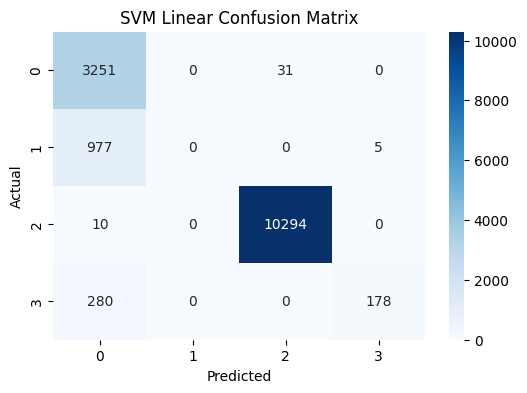


🔍 SVM RBF Evaluation
Accuracy: 0.9721150006655132
Precision: 0.9726140879842774
Recall: 0.9721150006655132
F1-score: 0.9694329223232366


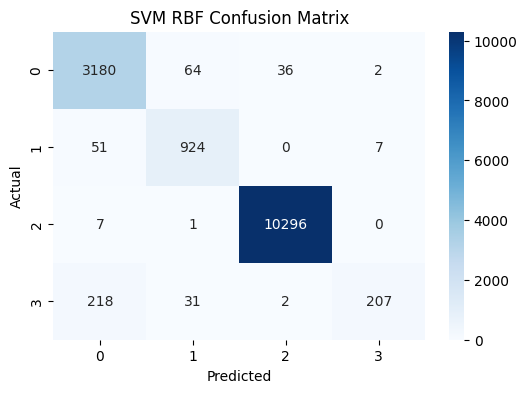


🔍 SVM Polynomial Evaluation
Accuracy: 0.9697857047783841
Precision: 0.9698299936101065
Recall: 0.9697857047783841
F1-score: 0.9671853036769715


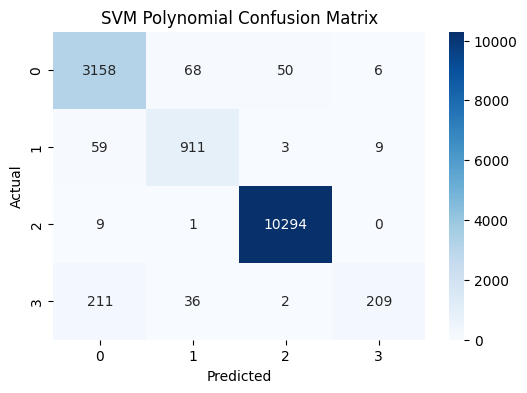


🔍 KNN k=3 Evaluation
Accuracy: 0.9797018501264475
Precision: 0.9791206786202186
Recall: 0.9797018501264475
F1-score: 0.9788575888860948


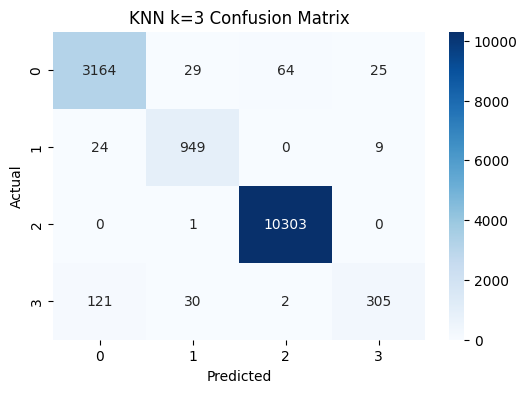


🔍 GaussianNB Evaluation
Accuracy: 0.9405031279116198
Precision: 0.9401346702206956
Recall: 0.9405031279116198
F1-score: 0.936063217467732


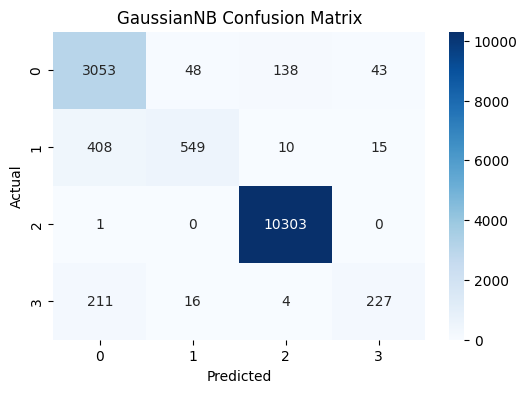


🔍 Decision Tree Evaluation
Accuracy: 0.9866231864767736
Precision: 0.9865213047146865
Recall: 0.9866231864767736
F1-score: 0.9865677963778188


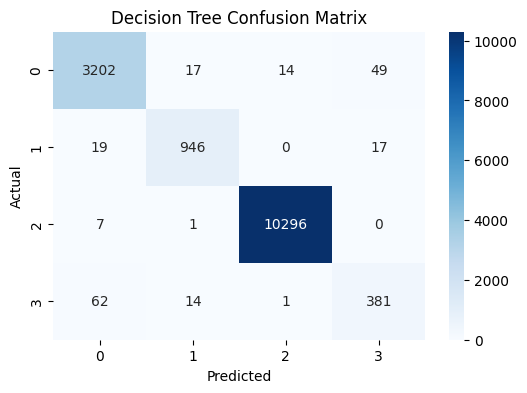


🔍 Random Forest Evaluation
Accuracy: 0.9905497138293624
Precision: 0.9904921054595048
Recall: 0.9905497138293624
F1-score: 0.9902506032940553


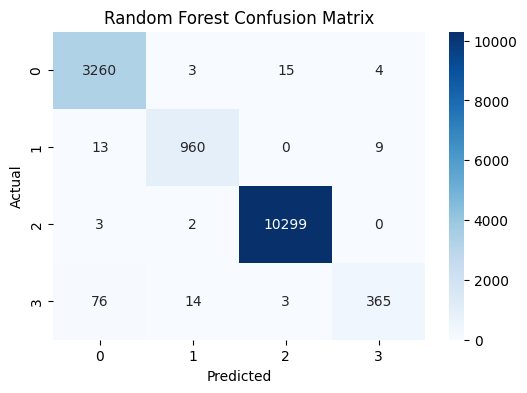


🔍 Voting Classifier Evaluation
Accuracy: 0.9885531744975377
Precision: 0.9885349757369253
Recall: 0.9885531744975377
F1-score: 0.9882247136724649


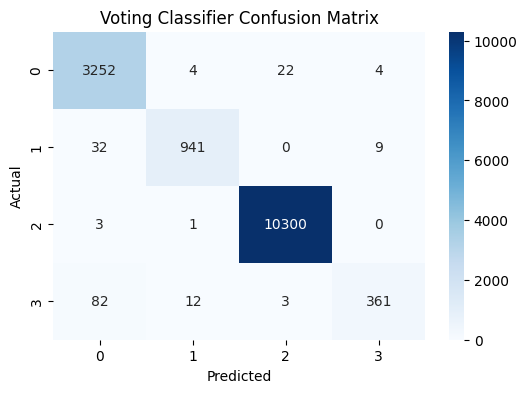


🔍 Stacking Classifier Evaluation
Accuracy: 0.9906828164514841
Precision: 0.9905360144634882
Recall: 0.9906828164514841
F1-score: 0.9905038301572228


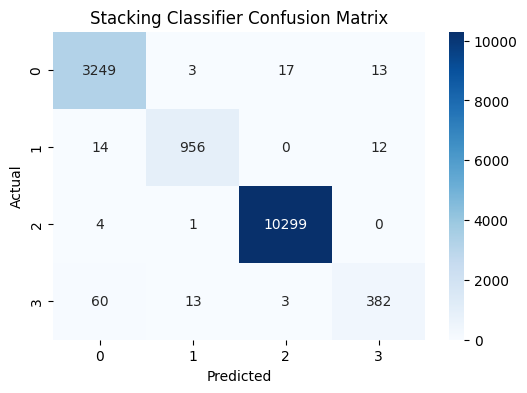

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(name, y_true, y_pred):
    print(f"\n🔍 {name} Evaluation")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1-score:", f1_score(y_true, y_pred, average='weighted'))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model("SVM Linear", y_test, y_pred_linear)
evaluate_model("SVM RBF", y_test, y_pred_rbf)
evaluate_model("SVM Polynomial", y_test, y_pred_poly)

evaluate_model("KNN k=3", y_test, y_pred_knn)
# evaluate_model("KNN k=5", y_test, y_pred_knn)
# evaluate_model("KNN k=7", y_test, y_pred_knn)

evaluate_model("GaussianNB", y_test, y_pred_gnb)
evaluate_model("Decision Tree", y_test, y_pred_dt)
evaluate_model("Random Forest", y_test, y_pred_rf)

evaluate_model("Voting Classifier", y_test, y_pred_vote)
evaluate_model("Stacking Classifier", y_test, y_pred_stack)


Part 3: Dimensionality Reduction
A. PCA (Principal Component Analysis)
1. Apply PCA to reduce dimensionality while preserving 95% of the variance.


In [20]:
from sklearn.decomposition import PCA

# Fit PCA on training data
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_encoded)
X_test_pca = pca.transform(X_test_encoded)

print("Original feature count:", X_train_encoded.shape[1])
print("Reduced feature count:", X_train_pca.shape[1])


Original feature count: 8
Reduced feature count: 7


2. Visualize the first two principal components

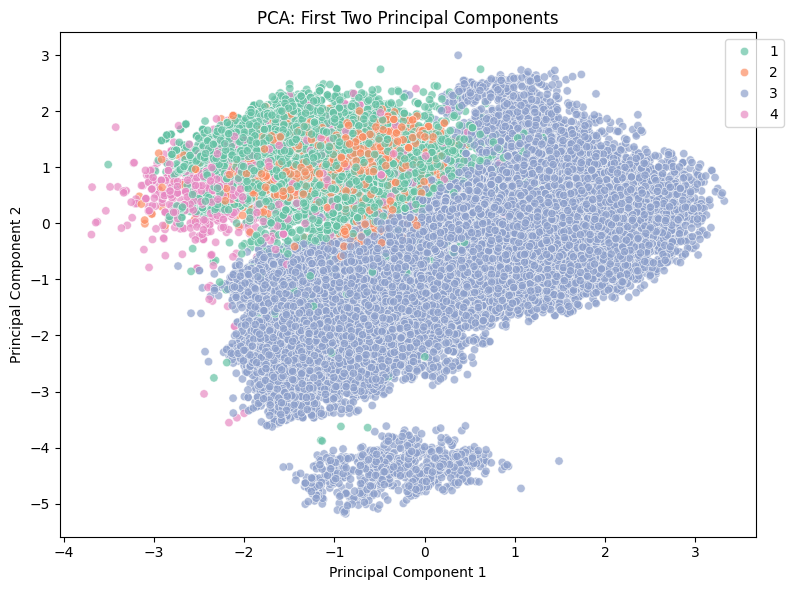

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for plotting
pca_df = pd.DataFrame(X_train_pca[:, :2], columns=["PC1", "PC2"])
pca_df["Activity"] = y_train.values

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Activity", palette="Set2", alpha=0.7)
plt.title("PCA: First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="best", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


B. SVD (Singular Value Decomposition)
1. Apply Truncated SVD on the same dataset and compare results with PCA.

In [22]:
from sklearn.decomposition import TruncatedSVD

# Use same number of components as PCA
n_components_pca = X_train_pca.shape[1]

svd = TruncatedSVD(n_components=n_components_pca, random_state=42)
X_train_svd = svd.fit_transform(X_train_encoded)
X_test_svd = svd.transform(X_test_encoded)

print("SVD reduced feature count:", X_train_svd.shape[1])


SVD reduced feature count: 7



2. Visualize reduced features for interpretability.

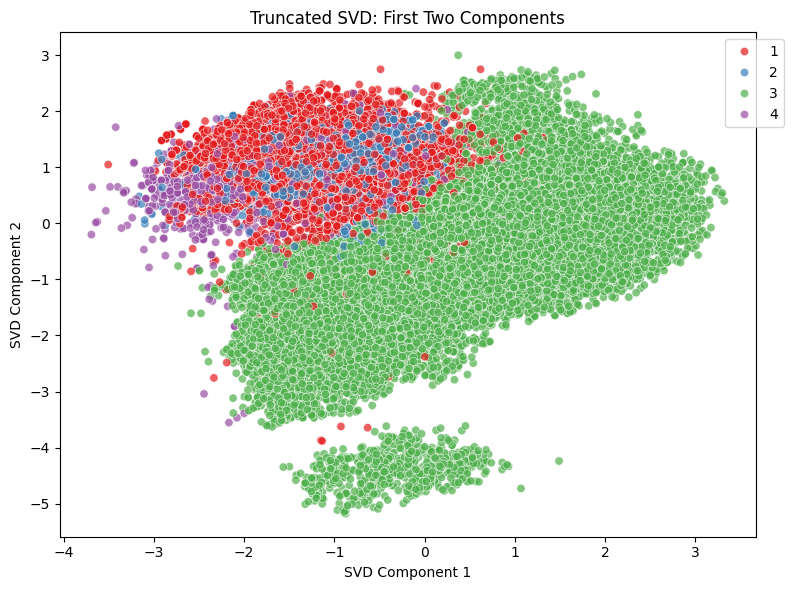

In [23]:
# Create DataFrame for plotting
svd_df = pd.DataFrame(X_train_svd[:, :2], columns=["SVD1", "SVD2"])
svd_df["Activity"] = y_train.values

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=svd_df, x="SVD1", y="SVD2", hue="Activity", palette="Set1", alpha=0.7)
plt.title("Truncated SVD: First Two Components")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.legend(loc="best", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


Part 4: Feature Selection Methods
Apply and compare the following Feature Selection (FS) techniques individually:
1. Variance Thresholding — remove low-variance features.

In [31]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.01)
X_train_vt = vt.fit_transform(X_train_encoded)
X_test_vt = vt.transform(X_test_encoded)


2. Correlation Filtering — drop features with high correlation (|ρ| > threshold).

In [32]:
import numpy as np

def correlation_filter(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)

X_train_cf = correlation_filter(X_train_encoded)
X_test_cf = X_test_encoded[X_train_cf.columns]


3. Chi-Square (χ²) — applicable to non-negative features.

In [34]:
from sklearn.feature_selection import SelectKBest, chi2

# Ensure non-negative features
X_train_chi = X_train_encoded.copy()
X_test_chi = X_test_encoded.copy()
X_train_chi[X_train_chi < 0] = 0
X_test_chi[X_test_chi < 0] = 0

chi = SelectKBest(score_func=chi2, k=7)
X_train_chi = chi.fit_transform(X_train_chi, y_train)
X_test_chi = chi.transform(X_test_chi)


4. Entropy / Mutual Information — estimate information gain using mutual_info_classif.

In [35]:
from sklearn.feature_selection import mutual_info_classif

mi = SelectKBest(score_func=mutual_info_classif, k=7)
X_train_mi = mi.fit_transform(X_train_encoded, y_train)
X_test_mi = mi.transform(X_test_encoded)


5. Sequential Feature Selection (SFS/SBS) — select optimal subsets using a base estimator.

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

sfs = SequentialFeatureSelector(RandomForestClassifier(n_estimators=50), n_features_to_select=7, direction='forward')
X_train_sfs = sfs.fit_transform(X_train_encoded, y_train)
X_test_sfs = sfs.transform(X_test_encoded)


Evaluate models using FS to analyze performance changes.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_fs(name, X_train, X_test):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n🔍 {name} Feature Selection")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

evaluate_fs("Variance Thresholding", X_train_vt, X_test_vt)
evaluate_fs("Correlation Filtering", X_train_cf, X_test_cf)
evaluate_fs("Chi-Square", X_train_chi, X_test_chi)
evaluate_fs("Mutual Information", X_train_mi, X_test_mi)
evaluate_fs("Sequential Feature Selection", X_train_sfs, X_test_sfs)
